In [1]:
# Exploring distributions of chemokine concentration sensitivity (threshold concentration at which cells switch 
# behaviour, e.g. become chemotactic). 
#
# Looking for distributions that yield only positive values, and ideally have as few parameters as possible. 
#
# Mark N. Read, 2018
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import seaborn as sns


In [2]:
def draw_distros(concentrations, cdfs, labels, xlog=False):
    sns.set_style('darkgrid')
    sns.set_context("talk")
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca()
    plots = []
    for cdf in cdfs:
        p = ax.plot(concentrations, cdf)
        plots.append(p)
    plt.legend( labels)
    ax.set_xlabel("Concentration (molecules)")
    ax.set_ylabel("Cumulative distribution")
    ax.set_xlim(xmin=min(concentrations), xmax=max(concentrations))
    if xlog:
        ax.set_xscale('log')
    plt.show()

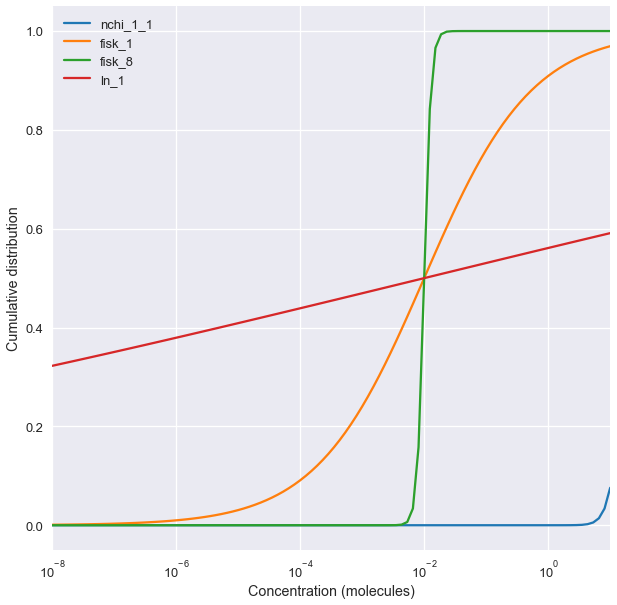

In [5]:
concentrations = np.logspace(-8, 1, num=100)

# Non-central chi squared. df="k" nc="lambda" from wikipedia. 
nchi2 = ss.ncx2(df=10., nc=10.)
cdf = nchi2.cdf(concentrations)

# Also known as log-logistic. 
cdf_fisk_a = ss.fisk.cdf(x=concentrations, c=0.5, scale=1e-2)
cdf_fisk_8 = ss.fisk.cdf(x=concentrations, c=8, scale=1e-2)

# Log normal
cdf_ln = ss.lognorm.cdf(x=concentrations, s=30, scale=1e-2)

draw_distros(concentrations, [cdf, cdf_fisk_a, cdf_fisk_8, cdf_ln], ['nchi_1_1', 'fisk_1', 'fisk_8', 'ln_1'], xlog=True)




In [41]:
concentrations = np.logspace(-4, 1, num=100)
print(concentrations)

[1.00000000e-04 1.12332403e-04 1.26185688e-04 1.41747416e-04
 1.59228279e-04 1.78864953e-04 2.00923300e-04 2.25701972e-04
 2.53536449e-04 2.84803587e-04 3.19926714e-04 3.59381366e-04
 4.03701726e-04 4.53487851e-04 5.09413801e-04 5.72236766e-04
 6.42807312e-04 7.22080902e-04 8.11130831e-04 9.11162756e-04
 1.02353102e-03 1.14975700e-03 1.29154967e-03 1.45082878e-03
 1.62975083e-03 1.83073828e-03 2.05651231e-03 2.31012970e-03
 2.59502421e-03 2.91505306e-03 3.27454916e-03 3.67837977e-03
 4.13201240e-03 4.64158883e-03 5.21400829e-03 5.85702082e-03
 6.57933225e-03 7.39072203e-03 8.30217568e-03 9.32603347e-03
 1.04761575e-02 1.17681195e-02 1.32194115e-02 1.48496826e-02
 1.66810054e-02 1.87381742e-02 2.10490414e-02 2.36448941e-02
 2.65608778e-02 2.98364724e-02 3.35160265e-02 3.76493581e-02
 4.22924287e-02 4.75081016e-02 5.33669923e-02 5.99484250e-02
 6.73415066e-02 7.56463328e-02 8.49753436e-02 9.54548457e-02
 1.07226722e-01 1.20450354e-01 1.35304777e-01 1.51991108e-01
 1.70735265e-01 1.917910

In [67]:
def ecdf(observations):
    """
    Empirical Cumulative Distribution Function.
    :param observations: list of observations, in any order.
    :return: a list of tuples: [ (<value>,<proportion of observations less than or equal to value>) ]
    Values will be given in ascending order.
    """
    s = sorted(observations)  # non-destructive, preserves original order of observations.
    n = len(s)  # number of observations.
    cdf = []
    for i, sample in enumerate(s):
        proportion = float(i + 1) / n
        tup = (sample, proportion)
        cdf.append(tup)
    return cdf


def plotCDFs(distributions, names=None, colours=None, xlabel=None, title=None, filename=None, fontsize=18,
             linewidth=2.0, xlog=False, xmin=None, xmax=None, line_styles=None, x_symlog_thresh=None,
             plot_uniform=False):
    """
    Calculates cumulative distribution functions for each distribution in the supplied list.
    :param distributions: list of lists. Each lower level list is a distribution to plot as empirical cdf
    :param names: name of each distribution, used for legend. List of strings.
    :param colours: list of objects interpretable as colours. If used, one per distribution. E.g. ['r','k','b','g']
    :param xlabel: xlabel of graph
    :param title: title of graph
    :param filename: if left as None, will show graph visually rather than save to filesystem. Leave off the extension
    (.png and similar), as these are added. Files saved as both svg and png.
    :param fontsize:
    :param linewidth:
    :param xlog: False, linear scale. True, log scale. 'symlog', symetrical log scale that has a section of linear
    around zero.
    :param x_symlog_thresh: Thresholds around zero for linear plot if 'symlog' selected.
    :param plot_uniform: if True, plot the distribution for a uniform distribution within the max and min values of the
    other distributions shown.
    """
    plt.clf()
    plots = []
    if line_styles is None:
        line_styles = ['-'] * len(distributions)
    legend_names = []
    if names is None:
        names = [None] * len(distributions)
    for i, (distro, name, ls) in enumerate(zip(distributions, names, line_styles)):
        if len(distro) > 0:
            cdf = ecdf(distro)
            # insert one record at start of these lists to ensure curves extend to y=0.
            D1X = [cdf[0][0]]
            D1X.extend([record[0] for record in cdf])
            D1Y = [0]
            D1Y.extend([record[1] for record in cdf])

            if colours:
                p1, = plt.plot(D1X, D1Y, linewidth=linewidth, color=colours[i])
            else:
                p1, = plt.plot(D1X, D1Y, linewidth=linewidth)
            plots.append(p1)
            legend_names.append(name)
    if plot_uniform:
        all_data = numpy.concatenate([numpy.array(d) for d in distributions])
        x_min = numpy.min(all_data)
        x_max = numpy.max(all_data)
        plt.plot((x_min, x_max), (0., 1.), linewidth=linewidth)
    if len(legend_names) > 0 and None not in legend_names:
        plt.legend(plots, legend_names, loc='lower right')
    plt.ylabel('Proportion')
    if xlabel:
        plt.xlabel(xlabel)
    if title:
        plt.title(title)
    plt.gca().grid(True, linewidth=linewidth)   # turn on grid lines.
    font = {'size': fontsize}
    plt.rc('font', **font)
    # change the width of the plot boundary lines
    ax = plt.gca()
    [i.set_linewidth(linewidth) for i in ax.spines.values()]
    if xmax is not None or xmin is not None:
        curXmin, curXmax = plt.gca().get_xlim()
        if xmax is not None:
            curXmax = xmax
        if xmin is not None:
            curXmin = xmin
        plt.gca().set_xlim([curXmin, curXmax])
    if xlog is True:
        plt.xscale('log')
    if xlog is 'symlog':
        if x_symlog_thresh:
            plt.xscale('symlog', linthreshx=x_symlog_thresh)
        else:
            plt.xscale('symlog')
    if filename:
        plt.savefig(filename + '.png', dpi=600)
        plt.savefig(filename + '.svg', dpi=600)
    else:
        plt.show()

0.006419265030936416
0.010837358360597852


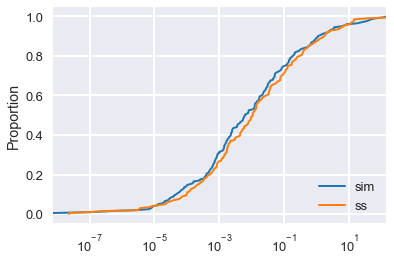

In [78]:
# Verify that java's commons.maths3.distribution.LogNormalDistribution does what it says.
data_sim = [4.8489288371715816E-4,4.111067526136268E-5,7.168153385820286E-4,1.204467343860299E-7,65.54702006611483,0.21261276435492335,1.112435619005914,5.1423173006136685E-5,0.0036416947963682712,0.029127895186298998,0.0023176558006042626,4.7962379066310393E-4,0.14313330374442096,2.844726334306337E-6,0.007974670003011457,0.001423666044020236,0.20344543599259007,0.014556148942962328,0.003565688179595098,0.011955996827145892,8.383498530248512E-4,0.005420578525913245,6.993566002776826E-9,0.18450136902635256,6.479322068309592E-4,0.001672719301374413,0.0010090785132474758,0.0485939931016361,0.012558172625387812,0.051115735804277515,0.08217000542220217,0.023102843547571673,0.005922024610891813,0.016861053704302135,0.030915327898088266,0.0014241278432057544,1.1722745182849699E-4,0.03419732448811593,7.5889305340902995,0.681025768398686,0.03668887984301989,5.670111507325E-4,7.356500137755417E-4,0.001254363457361936,0.14132583546834182,0.05253861858217124,0.056705951629263444,0.005402459067153173,0.05197637355373942,0.0022862004570204115,0.06569915367923325,4.018939274160855E-5,0.001500145126677038,0.031128804246009008,8.283019358342181E-5,0.012981889126322092,2.006778245317017E-5,0.027650608877874544,2.9783475748107592E-5,6.480471830037361E-4,1.617427329693198E-4,0.0027201049784281424,9.882967704911386E-5,0.0326593730049308,1.2679870001450778E-5,0.0026159589824762907,6.761548093006596E-4,0.020275790139178355,0.012382530074695454,4.025873219275653E-4,0.0023179703894796286,0.00645398189120373,0.07426962723708061,0.14420316790078908,0.022937814019333046,0.0013454900870720071,0.08377758605586644,7.836892228710513E-4,0.15587841688239332,0.0024988630500977767,0.027326402350599906,8.427260399958022E-4,3.4174577060931674E-5,2.331395955330354,1.0878128144559251,5.070117703547021E-4,0.01448341132797235,0.8705902078523083,0.0014100671378143267,0.05247033800194513,1.4943346607049317,6.146367841710117,5.944407272231114E-4,41.63349842628341,0.0016751040515901412,0.006384548170669102,0.001993259227762083,2.5893984372427928E-5,0.2882983749405387,7.659846927110833E-4,0.01623805730356635,0.002013594323920149,3.2855571983038113E-4,2.5772898516878166E-4,0.0056131666732742985,0.9505151021332915,0.13340577019630617,5.763416911037297E-5,0.9889355566307241,0.02401288843084225,4.0932652676740027E-4,8.938530607843508E-4,8.701454275827725E-6,24.213356851988856,0.104443235923604,0.15595116911193044,0.0077618940370438195,0.003832855400529543,0.005890480146772798,0.6578125710629465,0.011188348071597253,0.017415990496193422,0.0010139404982419818,6.681462967598723E-5,7.93839523057091E-6,0.002511988998134708,6.085449019253873E-4,2.8298500252861436E-5,0.0035236533642031766,0.5671100423635956,151.22186178015747,0.7287286820468627,0.09011912500543194,0.21310539248152782,1.792273350810333,7.211621301519902E-4,1.3044488347929026E-5,0.017287657763052158,0.0463781769270042,0.008052146082113264,2.07090181502799E-5,7.428262546311208E-5,0.3401236321918709,1.317709812045079,3.616807378002623E-4,0.3063377193856731,0.0017934320814274186,0.1272083967990811,4.036685968288214E-4,0.08696011643505866,1.4965296590048165E-4,0.00816660815031447,34.04646601899926,3.5636199106660156,0.017647349791315367,4.332815587587224E-7,18.13861650024834,0.4230783627263461,3.18813564912005,0.03165456307640467,9.686250009822011E-5,2.56241899249532,0.012711107182959348,0.0049758047856120185,2.6617347421635666,1.808095457683195E-5,2.518290500448476E-4,115.23449029896355,8.88551046015022E-6,0.12552170205481383,6.7725418902277935E-6,0.025553155392570227,8.560350857261455E-4,0.6660820403981647,0.0021970470663823212,0.8724081870526824,0.0016025785880644445,0.0460658917859524,0.012332482269994815,0.1773980546315995,4.6967731165742426E-5,47.69396516020593,0.0015421915247542405,0.23281416928887017,5.225630154054475E-4,1.6066512732626953E-4,0.037580790902652664,8.194236438355456E-5,3.5597002368610053,0.0013769935402528047,0.002480303273539973,3.534935312036638E-4,6.267236836911902E-5,8.478591128798168,0.022114005826544703,0.5449462776639188,9.003312197320438E-4,0.0043072005459907515,0.0018189704479012593,0.004493336542701644]
ln = ss.lognorm(s=4.0, scale=1e-2)
data_ss = ln.rvs(size=200)
print(np.median(data_sim))
print(np.median(data_ss))

#
# Java's implementation of this distribution differs from scipy in that the locations need to be either log(d) or
# exp(d) to align them. IE, they express the location differently, but a conversion exists. 
#
plotCDFs(distributions=[data_sim, data_ss], names=['sim', 'ss'], colours=None, xlabel=None, title=None, filename=None, fontsize=18,
             linewidth=2.0, xlog=True, xmin=min(data_sim), xmax=max(data_sim), line_styles=None, x_symlog_thresh=None,
             plot_uniform=False)

# print(max(data))
# fig = plt.figure(figsize=(10, 10))
# ax = fig.gca()
# sns.distplot(data, kde_kws=dict(cumulative=True), ax=ax)
# ax.set_xlim([min(data), max(data)])
# ax.set_xscale('log')
# plt.show()

In [18]:
A = np.linspace(0,10, 10)
print(A)

B = np.logspace(1e-1, 1e2, 10)
print(B)

C = np.linspace(0, 5, 10)

import itertools
print(list(itertools.product(A, B, C)))

[ 0.          1.11111111  2.22222222  3.33333333  4.44444444  5.55555556
  6.66666667  7.77777778  8.88888889 10.        ]
[1.25892541e+000 1.58489319e+011 1.99526231e+022 2.51188643e+033
 3.16227766e+044 3.98107171e+055 5.01187234e+066 6.30957344e+077
 7.94328235e+088 1.00000000e+100]
[(0.0, 1.2589254117941673, 0.0), (0.0, 1.2589254117941673, 0.5555555555555556), (0.0, 1.2589254117941673, 1.1111111111111112), (0.0, 1.2589254117941673, 1.6666666666666667), (0.0, 1.2589254117941673, 2.2222222222222223), (0.0, 1.2589254117941673, 2.7777777777777777), (0.0, 1.2589254117941673, 3.3333333333333335), (0.0, 1.2589254117941673, 3.8888888888888893), (0.0, 1.2589254117941673, 4.444444444444445), (0.0, 1.2589254117941673, 5.0), (0.0, 158489319246.11172, 0.0), (0.0, 158489319246.11172, 0.5555555555555556), (0.0, 158489319246.11172, 1.1111111111111112), (0.0, 158489319246.11172, 1.6666666666666667), (0.0, 158489319246.11172, 2.2222222222222223), (0.0, 158489319246.11172, 2.7777777777777777), (0.0, 

In [19]:
'log'=='log'

True